In [1]:
# --- imports and constants ----------------------------------------------------
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ENTITY   = "ziv-scully-group"       
PROJECT  = "StoppingBayesOptSynthetic"     
SWEEP_ID = "t9064eg1"             
kernel = "Matern52"
dimension = 8

TARGET_SEED      = 0               # pick the seed you want
TARGET_COST_TYPE = "linear"       # or "linear", etc.
MAX_RUNS_TO_PLOT = 6               # keep the figure readable

# --- load the sweep and filter runs ------------------------------------------
api = wandb.Api()
sweep_path = f"{ENTITY}/{PROJECT}"
runs = api.runs(path=sweep_path, filters={
        "sweep": SWEEP_ID,
        "config.dim": dimension,
        "config.kernel": kernel,
        "config.seed": TARGET_SEED,
        "config.cost": TARGET_COST_TYPE})

print(f"{len(runs)} runs after filtering (seed={TARGET_SEED}, cost_type={TARGET_COST_TYPE})")
# print(runs) #runs = runs[:MAX_RUNS_TO_PLOT]    # just grab the first fewi

6 runs after filtering (seed=0, cost_type=linear)


In [2]:
from collections import defaultdict
METRIC_KEYS    = ['LogEIC acq'] # , 'UCB-LCB acq', 'Regret-Gap acq'] # ['LogEIC acq'] # , 'UCB-LCB acq', 'Regret-Gap acq']

# policy_histories: {policy: {rule: pd.Series}}
acq_histories = defaultdict(dict)

for r in runs:
    policy = r.config.get('policy', r.name)
    hist = r.history(keys=METRIC_KEYS)

    for acq_function in METRIC_KEYS:
        # pref = rule_prefix.get(rule, rule)
        # find column that contains the prefix and ends with 'time'
        # cols = [c for c in hist.columns]
        # col = cols[0]

        series = (
            hist[acq_function]
            .fillna(0)
            .reset_index(drop=True)               # replace NaNs with 0 as requested
            .iloc[1:500]  
        )
        acq_histories[policy][acq_function] = series

print(acq_histories)

defaultdict(<class 'dict'>, {'Stable_Gittins_Lambda_1': {'LogEIC acq': 1     -1.326707
2     -2.037423
3      -2.16533
4     -1.853215
5     -1.806984
         ...   
495   -3.385635
496    -3.14769
497   -6.623522
498   -3.148371
499   -3.345008
Name: LogEIC acq, Length: 499, dtype: object}, 'Stable_Gittins_Lambda_01': {'LogEIC acq': 1     -1.326707
2     -2.037423
3     -2.161781
4     -2.312898
5     -2.194473
         ...   
495   -6.659394
496   -6.753203
497   -6.658374
498   -7.112389
499   -7.112699
Name: LogEIC acq, Length: 499, dtype: object}, 'Stable_Gittins_Lambda_001': {'LogEIC acq': 1     -1.326707
2     -2.037423
3     -2.014666
4     -2.095807
5     -1.545928
         ...   
495   -8.863781
496   -8.863752
497   -8.420962
498   -8.421062
499   -8.421685
Name: LogEIC acq, Length: 499, dtype: object}, 'LogEIWithCost': {'LogEIC acq': 1      -1.326707
2      -2.037423
3       -1.83201
4      -1.308109
5      -1.390071
         ...    
495    -7.573123
496   -10.018086
497  

In [3]:
color_dict = {
    'LogEIC':                  'tab:orange',
    'LogEIWithCost':           'tab:blue',
    'LogEIC-med':              'tab:blue',
    'Stable_Gittins_Lambda_1': 'tab:orange',
    'Stable_Gittins_Lambda_01':'tab:orange',
    'Stable_Gittins_Lambda_001':'tab:orange',
    'UpperConfidenceBound':    'tab:purple',
    'UCB-LCB':                 'tab:purple',
    'SRGap-med':               'tab:pink',
    'ThompsonSampling':        'tab:brown',
    'PRB_0_1':                 'tab:brown',
    'GSS':                     'tab:olive',
    'Convergence':             'tab:gray',
    'Hindsight':               'tab:red'
}

name_dict = {
    0.1: "λ = 0.1",
    0.01: "λ = 0.01",
    0.001: "λ = 0.001", 
    'Stable_Gittins_Lambda_1': "PBGI(0.1)",
    'Stable_Gittins_Lambda_01': "PBGI(0.01)",
    'Stable_Gittins_Lambda_001':"PBGI(0.001)",
    'LogEIWithCost':"LogEIC", 
    'UpperConfidenceBound': "LCB", 
    'ThompsonSampling': "TS", 
    'PRB_0_1': "PRB",
    'LogEIC': "PBGI/LogEIC",
    'LogEIC-med':"LogEIC-med", 
    'UCB-LCB': "UCB-LCB",
    'Convergence': "Convergence",
    'GSS': "GSS",
    'SRGap-med':"SRGap-med",
    'uniform': "Uniform Cost",
    'linear': "Linear Cost",
    'periodic': "Periodic Cost" 
}

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})

plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    # 'xtick.rotation': 45,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': False,  # we’ll call tight_layout() explicitly
})

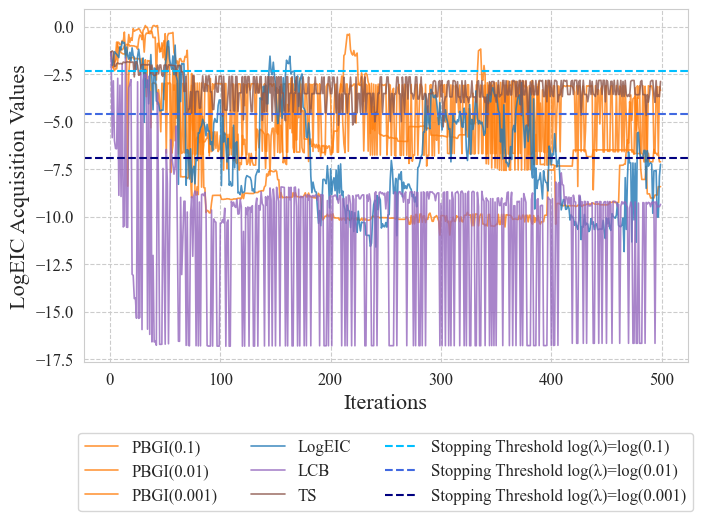

In [ ]:
def polyak_average(arr, window):
    """Compute Polyak average over a given window."""
    avg = np.full_like(arr, np.nan, dtype=float)
    cumsum = np.nancumsum(arr, dtype=float)
    for i in range(1, len(arr)):
        start = max(1, i - window + 1)
        total = cumsum[i] - (cumsum[start - 1] if start > 0 else 0.0)
        avg[i] = total / (i - start + 1)
    return avg


# --- plot wiggliness over optimiser steps ------------------------------------
# plt.figure(figsize=(6, 4))
# steps = np.arange(len(next(iter(traces.values()))))  # 0 … 500
fig, ax = plt.subplots(figsize=(9, 5))
steps = np.arange(1, 500)

acq_histories[policy][acq_function]
for metric_key in METRIC_KEYS:
    for policy, arr in acq_histories.items():
        ax.plot(steps, acq_histories[policy][metric_key], 
                        color=color_dict[policy], 
                        label=name_dict[policy], 
                        linewidth=1.2, 
                        alpha=0.8)

# add horizontal line at log(lambda)=log(0.01)
lambda_thresholds= [0.1, 0.01, 0.001]
threshold_colors = ["#00BFFF",  # lightblue  
                    "#4169E1",  # blue  
                    "#000080"]  # dark blue 
for i in range(len(lambda_thresholds)):
    threshold = lambda_thresholds[i]
    ax.axhline(
        y=np.log(threshold),
        linestyle="--",
        lw=1.5,
        color=threshold_colors[i],
        label=f"Stopping Threshold log(λ)=log({threshold})"
    )

# labels and title
# ax.set_title(f"wiggles (seed={TARGET_SEED}, cost={TARGET_COST_TYPE})")
# ax.set_xlabel("PBGI/LogEIC Stopping Rule Acquisition Value")
ax.set_xlabel("Iterations", fontsize=16)
ax.set_ylabel("LogEIC Acquisition Values", fontsize=16)

# move legend outside

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),   # just outside the top-right of the axes
    ncol=3,
    borderaxespad=0
)
'''
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=len(policies),
    fontsize=12
)
'''

# tighten layout, leaving room on the right for the legend
# plt.tight_layout(rect=[0, 0.05, 0.8, 1])   # leave space for the legend
plt.tight_layout(rect=[0, -0.1, 0.8, 1])
plt.savefig("../plots/PBGI_stopping_wiggly.pdf",bbox_inches="tight")
plt.show()

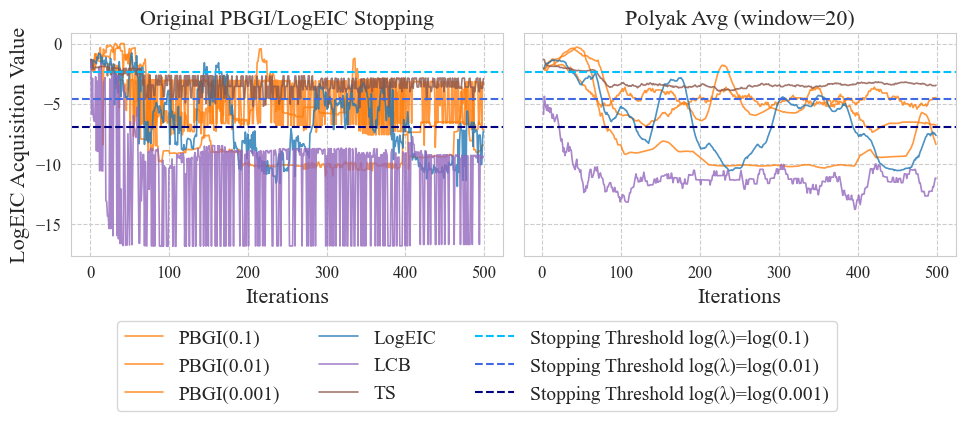

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def polyak_average(arr, window):
    """Compute Polyak average over a given window."""
    avg = np.full_like(arr, np.nan, dtype=float)
    cumsum = np.nancumsum(arr, dtype=float)
    for i in range(1, len(arr)):
        start = max(1, i - window + 1)
        total = cumsum[i] - (cumsum[start - 1] if start > 0 else 0.0)
        avg[i] = total / (i - start + 1)
    return avg

# parameters
steps = np.arange(1, 500)
lambda_thresholds = [0.1, 0.01, 0.001]
threshold_colors = ["#00BFFF", "#4169E1", "#000080"]
window_size = 20  # adjust polyak window here

# create two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for policy in acq_histories:
    name = name_dict[policy]
    color = color_dict[policy]
    # original on left
    ax1.plot(
        steps,
        acq_histories[policy]['LogEIC acq'],
        color=color,
        label=name,
        linewidth=1.2,
        alpha=0.8
    )
    # polyak‐averaged on right
    averaged = polyak_average(acq_histories[policy]['LogEIC acq'], window_size)
    ax2.plot(
        steps,
        averaged,
        color=color,
        label=name,
        linewidth=1.2,
        alpha=0.8
    )

# add horizontal threshold lines on both axes
for ax in (ax1, ax2):
    for thresh, col in zip(lambda_thresholds, threshold_colors):
        ax.axhline(
            y=np.log(thresh),
            linestyle="--",
            lw=1.5,
            color=col,
            label=f"Stopping Threshold log(λ)=log({thresh})"
        )

# labeling
for ax, title in zip((ax1, ax2), ("Original PBGI/LogEIC Stopping", f"Polyak Avg (window={window_size})")):
    ax.set_xlabel("Iterations", fontsize=16)
    ax.set_title(title, fontsize=16)
ax1.set_ylabel("LogEIC Acquisition Value", fontsize=16)

# one legend for entire figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.08),
            ncol=3,
            fontsize=14)

# tighten and save
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig("../plots/PBGI_stopping_wiggly_polyak.pdf", bbox_inches="tight")
plt.show()